# IBM Quantum Experience Lab - Lab script

Student Names: Parth Bhandari
               Sheila Perez 
               Charlie Solomons-Tuke

# Main Lab Exercise

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

Let us first figure out what we are expecting from our circuit.

The expectation value for any pair $(\theta, \phi)$ can be calculated explicitly;

\begin{equation}
    \bra{\phi}M(\theta)\ket{\phi}=\begin{pmatrix} \cos(\phi) & -\mathrm{i}\sin(\phi) \end{pmatrix}
    \begin{pmatrix} 0 & e^{-\mathrm{i}\theta} \\ e^{\mathrm{i}\theta} & 0 \end{pmatrix}
    \begin{pmatrix} \cos(\phi) \\ \mathrm{i}\sin(\phi) \end{pmatrix}
    = \mathrm{i}\cos(\phi)\sin(\phi)(e^{-\mathrm{i}\theta} - e^{\mathrm{i}\theta}) = \sin(2\phi)\sin(\theta)
\end{equation}


First, lets set up our imports, as well as some usefull functions. 

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
import matplotlib.pyplot as plt
import math
import numpy as np
import time
import pandas as pd
from tqdm import tqdm

#Function that returns the expectation value of a measurement
def get_expectation(circuit,backend,logshots):
    job = execute(circuit, backend,shots=2**logshots)
    counts = job.result().get_counts(circuit)
    runtime = job.result().time_taken
    keys = list(counts.keys())
    if set(keys) == set(['0','1']):
        return (counts['0']-counts['1'])/(counts['0']+counts['1']) , runtime
    elif keys == ['0']:
        return 1.0, runtime
    elif keys == ['1']:
        return -1.0, runtime

#Given an angle phi determines the state in our defined set of states
def initial_state(phi):
    state = math.cos(phi)*np.array([1,0]) + 1j*math.sin(phi)* np.array([0,1])
    return state

#Given data as a csv file and shots, returns histogram comparing the results with the true value of the expectation
#value and the mean of each method
def exp_value_histogram(data, state, shots,backend, mean=0.0, save = False):
    #data = pd.read_csv(f'{backend}_state_1.csv')
    M1 = data['Method 1']
    M2 = data['Method 2']
    n_simulations = len(M1)
    fig1, ax1 = plt.subplots(figsize=(8,5))
    bins=np.histogram(np.hstack((M1,M2)), bins=40)[1]
    ax1.hist(M1, bins, color='b', alpha=0.5, label=f'method 1')
    ax1.hist(M2, bins, color='r', alpha=0.5, label=f'method 2')
    ax1.axvline(mean, linestyle='-', c='g', label='True value')
    ax1.axvline(np.mean(M1), linestyle='-', c='b', label='Method 1 mean')
    ax1.axvline(np.mean(M2), linestyle='-', c='r', label='Method 2 mean')
    ax1.set_xlabel(r'Estimate of $\langle M\rangle$')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Results of {n_simulations} simulations of {2**shots} shots for {state} on {backend}')
    ax1.legend()
    if save == True:
        fig1.savefig(f'figures/{state}_{backend}.png')

def time_benchmarking(M1,M2,t1,t2,shots,exp_value):
    fig, axs = plt.subplots(1,2,figsize=(16,5))
    axs[0].plot(shots,t1, label='method 1')
    axs[0].plot(shots,t2, label='method 2')
    axs[0].set_xlabel('Number of shots')
    axs[0].set_ylabel('Time taken')
    axs[0].legend()

    axs[1].scatter(shots,M1, label='method 1')
    axs[1].scatter(shots,M2, label='method 2')
    axs[1].axhline(exp_value, label='expected value', c=(.7,.7,.7))
    axs[1].set_xlabel('Number of shots (log_2 scale)')
    axs[1].set_ylabel('Expectation value of M')
    axs[1].set_ylim([min(M1+M2)-0.05,max(M1+M2)+0.05])
    axs[1].legend()


Note that, when measuring, if a bit value doesn't occur in any shot it wont appear in the result dictionary. This can lead to key errors which we dodge by looking first at the keys before calculating expectations.

### Method 1

Note that $M = U(\theta)XU(\theta)^\dagger = U(\theta)HZHU(\theta)^\dagger$, so to measure M we just need to apply $HU(\theta)^\dagger$, and then measure $Z$. For $\theta = \pi/4$, $HU(\pi/4)^\dagger = HT^\dagger$

In [6]:
# Method 1 - apply HU^dagger(theta) and measure Z

#Build the cirquit
def method_1_circuit(theta, phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.p(-theta, qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    return circuit

circuit_drawer(method_1_circuit(theta=math.pi/8, phi=math.pi/4))

┌──────────────────────────────┐┌─────────┐┌───┐┌─┐
  q1: ┤ Initialize(0.70711,0.70711j) ├┤ P(-π/8) ├┤ H ├┤M├
      └──────────────────────────────┘└─────────┘└───┘└╥┘
c1: 1/═════════════════════════════════════════════════╩═
                                                       0

In [7]:
# Method 2
# M(theta) = cos(theta)X + sin(theta)Y
# alpha = cos(theta) ; beta = sin(theta)

#Build the cirquits

#Measure X expectation value circuit
def method_2_X_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit


circuit_drawer(method_2_X_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌───┐┌─┐
  q2: ┤ Initialize(1,0) ├┤ H ├┤M├
      └─────────────────┘└───┘└╥┘
c2: 1/═════════════════════════╩═
                               0

In [8]:
def method1(theta,phi,backend,shots):
    circuit = method_1_circuit(theta, phi)
    return get_expectation(circuit,backend,shots)

### Method 2

We use the identity $M(\pi/4) = \frac{1}{\sqrt{2}} X + Y $, then estimate $X$ and $Y$ independently.

Below we define functions for measuring x and y given a circuit and a clasical bit to perform the measurement on.

In [9]:
#Measure Y expectation value circuit
def method_2_Y_circuit(theta,phi):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    circuit = QuantumCircuit(qr, cr)
    circuit.initialize(initial_state(phi), qr[0])
    circuit.p(-math.pi/2,qr[0])
    circuit.h(qr[0])
    circuit.measure(qr[0],cr[0])
    circuit_drawer(circuit)
    return circuit

circuit_drawer(method_2_Y_circuit(theta=math.pi/4, phi=0))

┌─────────────────┐┌─────────┐┌───┐┌─┐
  q3: ┤ Initialize(1,0) ├┤ P(-π/2) ├┤ H ├┤M├
      └─────────────────┘└─────────┘└───┘└╥┘
c3: 1/════════════════════════════════════╩═
                                          0

In [10]:
def method2(theta,phi,backend,shots):
    '''
    Output: expectation value, job status of circuit X, job status of circuit Y
    '''
    circuit_X = method_2_X_circuit(theta, phi)
    expectation_X, runtime_X = get_expectation(circuit_X,backend,shots)
    circuit_Y = method_2_Y_circuit(theta,phi)
    expectation_Y, runtime_Y = get_expectation(circuit_Y,backend,shots)
    expectation_M = math.cos(theta)*expectation_X + math.sin(theta)*expectation_Y
    return expectation_M, runtime_X + runtime_Y

# Analysis with IBM simulator

We first retrieve the data on the IBM simulator

In [11]:
#Establish number of simulations, shots and backend simulator
n_simulations = 500
shots = 10 #log scale
backend = Aer.get_backend('qasm_simulator')

In [ ]:
#State 1
theta_1=math.pi/4
phi_1=0

method_1_state_1 = []
runtime_method_1_state_1 = []
for n in tqdm(range(n_simulations)):
    exp_value,runtime = method1(theta_1,phi_1,backend,shots)
    method_1_state_1.append(exp_value)
    runtime_method_1_state_1.append(runtime)


m1_dict = {'Method 1':method_1_state_1, 'Method 1 runtime':runtime_method_1_state_1}
pd.DataFrame(m1_dict).to_csv(f'{backend}_state_1.csv')

In [ ]:
method_2_state_1 = []
runtime_method_2_state_1 = []
for n in tqdm(range(n_simulations)):
    exp_value,runtime = method2(theta_1,phi_1,backend,shots)
    method_2_state_1.append(exp_value)
    runtime_method_2_state_1.append(runtime)

m1_dict.update({'Method 2':method_2_state_1, 'Method 2 runtime':runtime_method_2_state_1})
pd.DataFrame(m1_dict).to_csv(f'{backend}_state_1.csv')

In [14]:
#State 2
theta_2=math.pi/8
phi_2=math.pi/4

method_1_state_2 = []
runtime_method_1_state_2 = []
for n in tqdm(range(n_simulations)):
    exp_value, runtime = method1(theta_2,phi_2,backend,shots)
    method_1_state_2.append(exp_value)
    runtime_method_1_state_2.append(runtime)

m2_dict = {'Method 1':method_1_state_2,'Method runtime':runtime_method_1_state_2}
pd.DataFrame(m2_dict).to_csv(f'{backend}_state_2.csv')


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 114.54it/s]


In [17]:
method_2_state_2 = []
runtime_method_2_state_2 = []
for n in tqdm(range(n_simulations)):
    exp_value, runtime = method2(theta_2,phi_2,backend,shots)
    method_2_state_2.append(exp_value)
    runtime_method_2_state_2.append(runtime)

m2_dict.update({'Method 2':method_2_state_2,'Method 2 runtime':runtime_method_2_state_2})
pd.DataFrame(m2_dict).to_csv(f'{backend}_state_2.csv')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 60.34it/s]


## Expectation values

We compare our results for the expectation values for each of the pairs

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$

## Pair 1:  𝜃=𝜋/4,  𝜙=0

When $\phi=0$ the state is simply $\ket{0}$. Since this is the default state for a fresh qubit in QISKIT, we don't need to do anything to our qubit to reach the correct state.

For $\theta = \pi /4$, the observable in question is

$$ M(\pi/4) = \begin{pmatrix} 0 & \frac{1-i}{\sqrt{2}} \\ \frac{1+i}{\sqrt{2}} & 0
\end{pmatrix}$$

and through explicit calculation we have that $\langle M\rangle = 0$

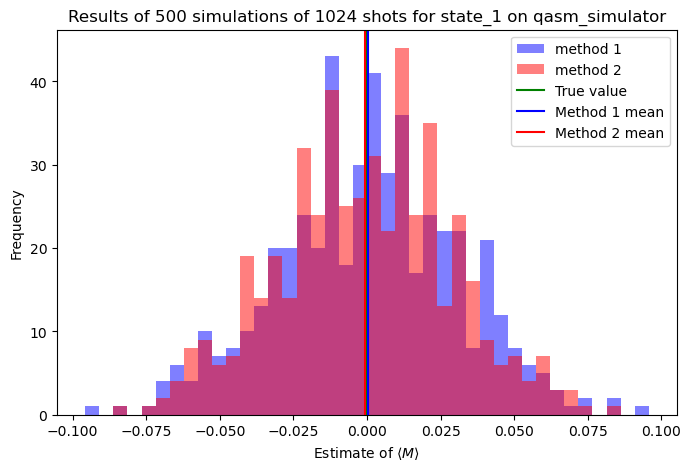

In [15]:
state_1_data = pd.read_csv(f'{backend}_state_1.csv')
state_1 = r'$\theta=\pi/4, \phi=0$'
exp_value_histogram(state_1_data, 'state_1', shots,backend, save = True)

## Pair 2:  𝜃=𝜋/8,  𝜙=𝜋/4

For $\phi = \pi/4$ the input state is $\frac{1}{\sqrt{2}}(\ket{0} + i\ket{1}) = \mathrm{exp}(-i\pi/4)HU(-\pi/2)H\ket{0}$. 

The formula for the expectation value above gives $\langle M\rangle = \sin(\pi/8) \approx 0.3827$.

To initialise the state we use the following function:

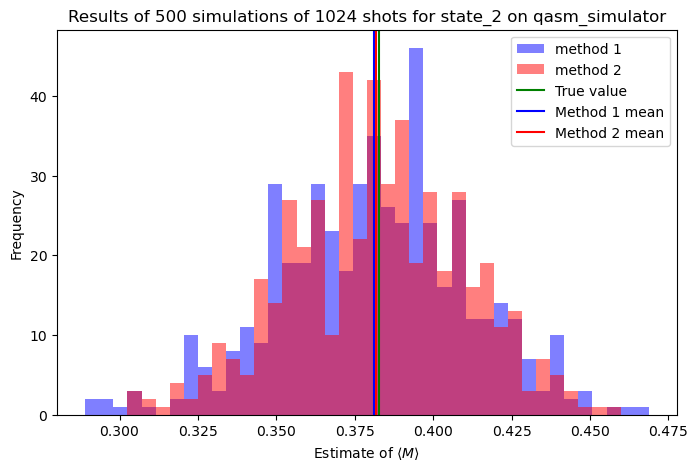

In [20]:
state_2_data = pd.read_csv(f'{backend}_state_2.csv')
state_2 = r'$\theta=\pi/8, \phi=\pi/4$'
exp_value_histogram(state_2_data, 'state_2', shots,backend, mean=0.3827, save = True)

## Time benchmarking

The time taken for each method to calculate expectation values is an important test of its usefulness. The full time taken for a given method is slightly ambiguous, as different user requirements might end up bottlenecking different parts of the calculation. 

For instance, we have assumed $M$ is of a fixed form which in turn makes the VQE decomposition very easy, and the state preparation in the basis rotation method easier also. For a more general observable $A$ we might wish to have a subroutine which performs the decomposition/finds the rotation matrix respectively, which may affect the performance. However, these tasks only need to be performed once at the start of the computation, so become irrelevant for larger numbers of iterations.

Let's assess how time taken scales with iteration number:

In [ ]:
shots = np.arange(1000, 100000, 1000)
shots_log = list(map(lambda x: math.log(x,2), shots))

method_1_state_1 = []
runtime_method_1_state_1 = []
for s in tqdm(shots_log):
    exp_value,runtime = method1(theta_1,phi_1,backend,s)
    method_1_state_1.append(exp_value)
    runtime_method_1_state_1.append(runtime)


method_2_state_1 = []
runtime_method_2_state_1 = []
for s in tqdm(shots_log):
    exp_value,runtime = method2(theta_1,phi_1,backend,s)
    method_2_state_1.append(exp_value)
    runtime_method_2_state_1.append(runtime)

time_benchmarking(method_1_state_1, method_2_state_1,runtime_method_1_state_1,runtime_method_2_state_1,shots,0)


To quantify the quality of the simulation, we have to quantify the time taken to get below a vertain error threshold. To calculate the average time taken, we can leverage the fact that the the time/shot is roughly constant:


In [ ]:
tps_1 = np.mean(np.array(runtime_method_1_state_1)/np.array(shots))
tps_2 = np.mean(np.array(runtime_method_2_state_1)/np.array(shots))
print('Ratio of time taken (method 2:method 1) = ', round(tps_2/tps_1, 3))

For calulating error at a given shot value, we need a characteristic standard deviation as a function of shots. Statistics suggest the deviation should scale with the inverse square root of the number of measurements.


In [ ]:
shots_std = np.linspace(500,2000,15)
shots_log = list(map(lambda x: math.log(x,2), shots_std))
n_simulations = 50

std1 = []
rt1 = []
for s in tqdm(shots_log):
    method_1_state_1 = []
    runtime_method_1_state_1 = []
    for i in range(n_simulations):
        exp_value,runtime = method1(theta_1,phi_1,backend,s)
        method_1_state_1.append(exp_value)
        runtime_method_1_state_1.append(runtime)
    std1.append(np.std(method_1_state_1))
    rt1.append(np.mean(runtime_method_1_state_1))

std2 = []
rt2 = []
for s in tqdm(shots_log):
    method_2_state_1 = []
    runtime_method_2_state_1 = []
    for i in range(n_simulations):
        exp_value,runtime = method2(theta_1,phi_1,backend,s)
        method_2_state_1.append(exp_value)
        runtime_method_2_state_1.append(runtime)
    std2.append(np.std(method_2_state_1))
    rt2.append(np.mean(runtime_method_2_state_1))


In [ ]:

fig, axs = plt.subplots(1,2,figsize=(16,5))
axs[0].plot(shots_std,rt1, label='method 1', c='r')
axs[0].plot(shots_std,rt2, label='method 2', c='b')
axs[0].set_xlabel('Number of shots')
axs[0].set_ylabel('Mean time taken')
axs[0].legend()

rt_s = np.sqrt(1/np.array(shots_std))
axs[1].scatter(rt_s, std1, label='method 1', c='r')
axs[1].plot(rt_s, rt_s*np.polyfit(rt_s, std1,1)[0]+ np.polyfit(rt_s, std1,1)[1],
            c='r', alpha=.5, label='m='+str(round(np.polyfit(rt_s, std1,1)[0],3)))

axs[1].scatter(rt_s, std2, label='method 2', c='b')
axs[1].plot(rt_s, rt_s*np.polyfit(rt_s, std2,1)[0]+ np.polyfit(rt_s, std2,1)[1],
            c='b', alpha=.5, label='m='+str(round(np.polyfit(rt_s, std2,1)[0],3)))
axs[1].set_xlabel(r'shots$^{-1/2}$')
axs[1].set_ylabel(r'$\Delta\langle M\rangle$')
axs[1].legend()

In either case, the error is roughly $\Delta\langle M\rangle \approx n_{shots}^{-1/2}$, so the only real difference between the two methods is the time taken; the VQE approach is significantly worse in that it is slower by a factor of $\sim 1.9$

# Analysis with IBM chip

In [ ]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
mykey = 'd0db27e06149ec7280499124f8a6a11cf87d70d35c06147d3f70a8f9c0ae5a136f33ae887c14b0b44c10c1dc64e3249cc89aa7104fc3e01c940a3e1f1dead7fc'
IBMQ.save_account(mykey)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend=least_busy(small_devices)

print(backend)

Data retrieval

In [ ]:
n_simulations = 20
shots = 10 #log scale

#State 1
theta_1=math.pi/4
phi_1=0
method_1_state_1 = []
runtime_method_1_state_1 = []
for n in tqdm(range(n_simulations)):
    exp_value,runtime = method1(theta_1,phi_1,backend,shots)
    method_1_state_1.append(exp_value)
    runtime_method_1_state_1.append(runtime)


m1_dict = {'Method 1':method_1_state_1, 'Method 1 runtime':runtime_method_1_state_1}
pd.DataFrame(m1_dict).to_csv(f'{backend}_state_1.csv')



In [ ]:
method_2_state_1 = []
runtime_method_2_state_1 = []
for n in tqdm(range(n_simulations)):
    exp_value,runtime = method2(theta_1,phi_1,backend,shots)
    method_2_state_1.append(exp_value)
    runtime_method_2_state_1.append(runtime)

m1_dict.update({'Method 2':method_2_state_1, 'Method 2 runtime':runtime_method_2_state_1})
pd.DataFrame(m1_dict).to_csv(f'{backend}_state_1.csv')

In [ ]:
#State 2
theta_2=math.pi/8
phi_2=math.pi/4

method_1_state_2 = []
runtime_method_1_state_2 = []
for n in tqdm(range(n_simulations)):
    exp_value, runtime = method1(theta_2,phi_2,backend,shots)
    method_1_state_2.append(exp_value)
    runtime_method_1_state_2.append(runtime)

m2_dict = {'Method 1':method_2_state_1,'Method 1 runtime':runtime_method_1_state_2}
pd.DataFrame(m2_dict).to_csv(f'{backend}_state_2.csv')


In [ ]:
method_2_state_2 = []
runtime_method_2_state_2 = []
for n in tqdm(range(n_simulations)):
    exp_value, runtime = method2(theta_2,phi_2,backend,shots)
    method_2_state_2.append(method2(exp_value))
    runtime_method_2_state_2.append(runtime)

m2_dict.update({'Method 2':method_2_state_2,'Method 2 runtime':runtime_method_2_state_2})
pd.DataFrame(m2_dict).to_csv(f'{backend}_state_2.csv')

Expectation value analysis

In [ ]:
n_simulations = 20
shots = 10 #log scale
backend = 'ibmq_belem'
state_1_data = pd.read_csv(f'{backend}_state_1.csv')
state_1 = r'$\theta=\pi/4, \phi=0$'
exp_value_histogram(state_1_data, 'state_1', shots,backend, save = True)

In [ ]:
state_2_data = pd.read_csv(f'{backend}_state_2.csv')
state_2 = r'$\theta=\pi/8, \phi=\pi/4$'
exp_value_histogram(state_2_data, 'state_2', shots,backend, mean=0.3827, save = True)

Runtime analysis

In [ ]:
#State 1
runtime_method_1_state_1_mean = np.mean(state_1_data['Method 1 runtime'])
print(f'The mean runtime for method 1 for state 1 is: {runtime_method_1_state_1_mean} s')
runtime_method_2_state_1_mean = np.mean(state_1_data['Method 2 runtime'])
print(f'The mean runtime for method 2 for state 1 is: {runtime_method_2_state_1_mean} s')